In [1]:
import pandas as pd

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

In [20]:
df_jan = pd.read_parquet('../data/green_tripdata_2021-01.parquet')

In [21]:
df_feb = pd.read_parquet('../data/green_tripdata_2021-02.parquet')

In [22]:
df_jan.shape, df_feb.shape

((76518, 20), (64572, 20))

In [23]:
df_jan[df_jan.trip_type == 2]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
6,2,2021-01-01 00:19:14,2021-01-01 00:19:21,N,5.0,265,265,1.0,0.00,180.0,0.0,0.0,36.06,0.0,None,0.3,216.36,1.0,2.0,0.0
15,2,2021-01-01 00:29:05,2021-01-01 00:29:07,N,5.0,42,264,1.0,0.00,10.0,0.0,0.0,2.06,0.0,None,0.3,12.36,1.0,2.0,0.0
30,2,2021-01-01 00:35:29,2021-01-01 00:55:15,N,5.0,74,247,1.0,3.64,13.0,0.0,0.0,0.00,0.0,None,0.3,13.30,2.0,2.0,0.0
43,2,2021-01-01 23:12:41,2021-01-02 01:13:53,N,5.0,95,82,1.0,0.00,9.7,0.0,0.0,2.00,0.0,None,0.3,12.00,1.0,2.0,0.0
45,2,2021-01-01 01:49:29,2021-01-01 01:49:33,N,5.0,244,244,5.0,0.02,12.0,0.0,0.0,2.46,0.0,None,0.3,14.76,1.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40363,2,2021-01-31 19:26:20,2021-01-31 19:35:47,N,5.0,167,248,2.0,1.31,10.0,0.0,0.0,0.00,0.0,None,0.3,10.30,2.0,2.0,0.0
40364,2,2021-01-31 19:44:54,2021-01-31 20:19:56,N,5.0,147,147,2.0,6.97,30.0,0.0,0.0,0.00,0.0,None,0.3,30.30,2.0,2.0,0.0
40377,2,2021-01-31 20:09:41,2021-01-31 20:10:21,N,5.0,95,95,1.0,0.00,15.0,0.0,0.0,3.06,0.0,None,0.3,18.36,1.0,2.0,0.0
40394,2,2021-01-31 20:38:42,2021-01-31 20:38:45,N,5.0,75,264,1.0,0.00,5.0,0.0,0.0,0.20,0.0,None,0.3,5.50,1.0,2.0,0.0


In [26]:
df_jan["trip_duration"] = df_jan.lpep_dropoff_datetime - df_jan.lpep_pickup_datetime

In [28]:
df_jan["trip_duration"] = df_jan.trip_duration.apply(lambda td: td.total_seconds()/60)

In [29]:
df_jan["trip_duration"]

0         3.933333
1         8.750000
2         5.966667
3         7.083333
4         0.066667
           ...    
76513    38.000000
76514    38.000000
76515    11.000000
76516    27.000000
76517    10.000000
Name: trip_duration, Length: 76518, dtype: float64

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='trip_duration', ylabel='Density'>

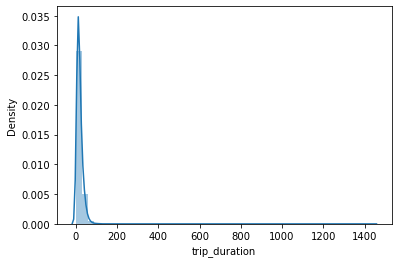

In [36]:
sns.distplot(df_jan.trip_duration)

In [38]:
df_jan.trip_duration.describe(percentiles=[0.95,0.98,0.99])

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
50%         13.883333
95%         44.000000
98%         56.000000
99%         67.158167
max       1439.600000
Name: trip_duration, dtype: float64

In [43]:
df_jan[(df_jan.trip_duration>=1) & (df_jan.trip_duration<=60)]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,trip_duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.50,...,0.5,0.00,0.00,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.00,...,0.5,2.81,0.00,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.00,...,0.5,1.00,0.00,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.00,...,0.5,0.00,0.00,None,0.3,9.30,2.0,1.0,0.00,7.083333
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.50,...,0.5,0.96,0.00,None,0.3,5.76,1.0,1.0,0.00,2.316667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,2,2021-01-31 21:38:00,2021-01-31 22:16:00,None,NaN,81,90,NaN,17.63,56.23,...,0.0,0.00,6.12,None,0.3,65.40,NaN,NaN,NaN,38.000000
76514,2,2021-01-31 22:43:00,2021-01-31 23:21:00,None,NaN,35,213,NaN,18.36,46.66,...,0.0,12.20,6.12,None,0.3,65.28,NaN,NaN,NaN,38.000000
76515,2,2021-01-31 22:16:00,2021-01-31 22:27:00,None,NaN,74,69,NaN,2.50,18.95,...,0.0,0.00,0.00,None,0.3,22.00,NaN,NaN,NaN,11.000000
76516,2,2021-01-31 23:10:00,2021-01-31 23:37:00,None,NaN,168,215,NaN,14.48,48.87,...,0.0,0.00,6.12,None,0.3,58.04,NaN,NaN,NaN,27.000000


In [40]:
(df_jan.trip_duration<=60).mean()

0.9848140306855904